In [124]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
%matplotlib inline
import matplotlib.pyplot as plt
from net.origin_net import Net
import pickle

In [48]:
net = Net()
out = net.build_origin_net(1.0)

In [2]:
model_path = './checkpoints/net_2018-12-19-10-05-17.ckpt-99900'

In [3]:
model_path = './checkpoints/net_2018-12-19-10-05-17.ckpt-99900'
reader = tf.train.NewCheckpointReader(model_path)
all_variables = reader.get_variable_to_shape_map()

In [4]:
all_variables

{'conv1/biases': [16],
 'conv1/weights': [3, 3, 1, 16],
 'conv2/biases': [32],
 'conv2/weights': [3, 3, 16, 32],
 'conv3/biases': [32],
 'conv3/weights': [3, 3, 32, 32],
 'fc1/biases': [128],
 'fc1/weights': [512, 128],
 'fc2/biases': [256],
 'fc2/weights': [128, 256],
 'global_step': [],
 'logits/biases': [10],
 'logits/weights': [256, 10]}

# 1. pure conv1的权重

### 1.1 处理 conv1 的权重

In [7]:
# 分析 conv1 的权重
conv1_weight = reader.get_tensor("conv1/weights")
conv1_weight.shape

(3, 3, 1, 16)

In [8]:
# 计算每个kernel权重的和 (也可以使用其他指标，如std，mean等)
conv1_weight_sum = np.sum(conv1_weight, (0,1,2))
sort_conv1_weights = np.sort(conv1_weight_sum)

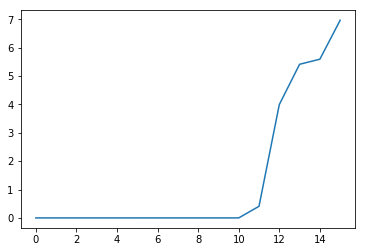

In [9]:
# 绘制conv1的
x = np.arange(0,len(sort_conv1_weights),step=1)
plt.plot(x,sort_conv1_weights)

有近10个kernel的权重和几乎为0，所以可以视为其对模型没有贡献，为保证kernel数为4的倍数，删除kernel和最小的8个kernel

In [11]:
pure_conv1_weight_index = np.where(conv1_weight_sum >= sort_conv1_weights[8])
pure_conv1_weight = conv1_weight[:,:,:,pure_conv1_weight_index[0]]

In [12]:
# conv1对应的bias 也做相同处理
conv1_bias = reader.get_tensor("conv1/biases")
pure_conv1_bias = conv1_bias[pure_conv1_weight_index[0]]
pure_conv1_bias

array([ 0.00045041,  0.0262382 ,  0.0208248 , -0.00159773,  0.09998561,
       -0.00079513,  0.00963001, -0.00306746], dtype=float32)

### 1.2 处理接续 conv1 后面一层的权重

conv1 kernel个数删减后，导致输出层的channel也会减少，所以对应后面一层的kernel通道也要减少 （对pooling层没有影响）
对于本例，conv1的kernel个数为8，所以后一层kernel的通道数也要删减对应通道，对bias无影响

In [22]:
conv2_weight = reader.get_tensor("conv2/weights")
conv2_bias = reader.get_tensor("conv2/biases")

In [23]:
conv2_weight = conv2_weight[:,:,pure_conv1_weight_index[0],:]

# 2. pure conv2的权重

### 2.1 处理conv2的权重
在上一步的基础上删减conv2的kernel个数

In [25]:
# 同理 先计算每个kernel 的权重和 找到最无关的一些kernel
conv2_weight_sum = np.sum(conv2_weight, (0,1,2))
sort_conv2_weights = np.sort(conv2_weight_sum)

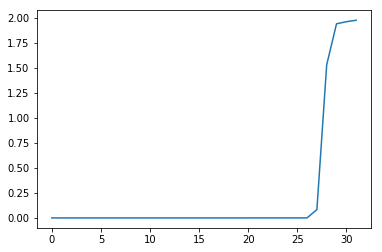

In [26]:
# 绘制conv2的权重和分布图
x = np.arange(0,len(sort_conv2_weights),step=1)
plt.plot(x,sort_conv2_weights)

删除权重和最小16个kernel

In [29]:
pure_conv2_weight_index = np.where(conv2_weight_sum >= sort_conv2_weights[16])
pure_conv2_weight = conv2_weight[:,:,:,pure_conv2_weight_index[0]]
pure_conv2_weight.shape

(3, 3, 8, 16)

In [32]:
# conv2对应的bias 也做相同处理
pure_conv2_bias = conv2_bias[pure_conv2_weight_index[0]]
pure_conv2_bias

array([-0.09783957, -0.04131799, -0.02566011, -0.06543457,  0.06472238,
       -0.00545198, -0.00474992, -0.02188597, -0.11222503, -0.006201  ,
       -0.0155636 ,  0.13311498, -0.00833193, -0.02097046,  0.02653153,
       -0.00043905], dtype=float32)

### 2.2 处理接续conv2后面一层的kernel

In [35]:
conv3_weight = reader.get_tensor("conv3/weights")
conv3_bias = reader.get_tensor("conv3/biases")

In [36]:
conv3_weight = conv3_weight[:,:,pure_conv2_weight_index[0],:]
conv3_weight.shape

(3, 3, 16, 32)

# 3. pure conv3的权重

### 3.1 处理conv3的权重

In [37]:
conv3_weight_sum = np.sum(conv3_weight, (0,1,2))
sort_conv3_weights = np.sort(conv3_weight_sum)

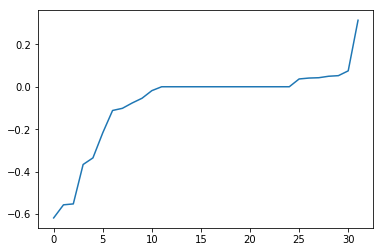

In [38]:
# 绘制conv3的权重和分布图
x = np.arange(0,len(sort_conv3_weights),step=1)
plt.plot(x,sort_conv3_weights)

conv3的权重和均很小，再观察conv3权重的std

In [40]:
conv3_weight_std = np.std(conv3_weight, (0,1,2))
sort_conv3_weights_std = np.sort(conv3_weight_std)

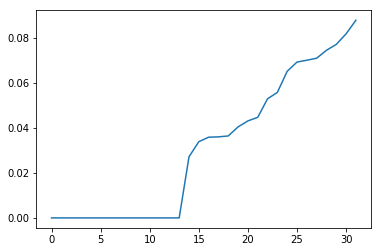

In [41]:
# 绘制conv3的权重std分布图
x = np.arange(0,len(sort_conv3_weights_std),step=1)
plt.plot(x,sort_conv3_weights_std)

可以看到有13个kernel的权重几乎无变化，删除8个无变化的kernel

In [42]:
pure_conv3_weight_index = np.where(conv3_weight_std >= sort_conv3_weights_std[8])
pure_conv3_weight = conv3_weight[:,:,:,pure_conv3_weight_index[0]]
pure_conv3_weight.shape

(3, 3, 16, 24)

In [43]:
# conv3对应的bias 也做相同处理
pure_conv3_bias = conv3_bias[pure_conv3_weight_index[0]]
pure_conv3_bias

array([-0.01627444,  0.00682878, -0.1715058 , -0.03838071, -0.0669011 ,
       -0.08104476,  0.01727855, -0.08151158, -0.07405551, -0.0405109 ,
       -0.05420913, -0.06136179, -0.07107263, -0.10885695, -0.00152763,
       -0.11885452, -0.07630014, -0.06948757, -0.04368662, -0.03982251,
       -0.09128781, -0.07677395, -0.04346057,  0.006544  ], dtype=float32)

### 3.2 处理接续 conv3 后面的全连接层的权重

flatten 层处理多维数据时，是按照 c w h b 依次处理，所以接续 conv层 的 dense层只保留每个神经元的 c, 2c, ... , o_w x o_h x c 对应的元素

In [44]:
fc1_weight = reader.get_tensor("fc1/weights")
fc1_bias = reader.get_tensor("fc1/biases")

In [73]:
fc1_weight.shape

(512, 128)

fc1前面接续的是pool3层，先获得pool3层的输出维度

In [55]:
# b h w c
out['pool3'].get_shape()

TensorShape([Dimension(8), Dimension(4), Dimension(4), Dimension(32)])

In [56]:
out_area = out['pool3'].get_shape()[1].value * out['pool3'].get_shape()[2].value

In [68]:
pure_index = []
for i in range(out_area):
    pure_index += list(32 * i + pure_conv3_weight_index[0]) 

In [74]:
fc1_weight = fc1_weight[pure_index, :]

# 4. pure fc1 的权重

fc kernel删减基本逻辑与conv相同

In [78]:
# 获得每个kernel的权重和
fc1_weight_sum = np.sum(fc1_weight, (0,))
sort_fc1_weights = np.sort(fc1_weight_sum)

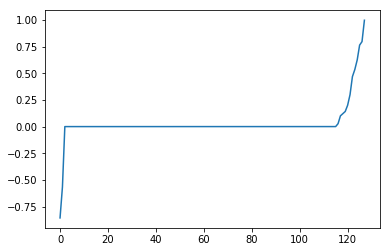

In [79]:
# 绘制fc1的权重和分布图
x = np.arange(0,len(sort_fc1_weights),step=1)
plt.plot(x,sort_fc1_weights)

In [81]:
# 获得每个kernel的std
fc1_weight_std = np.std(fc1_weight, (0,))
sort_fc1_weights_std = np.sort(fc1_weight_std)

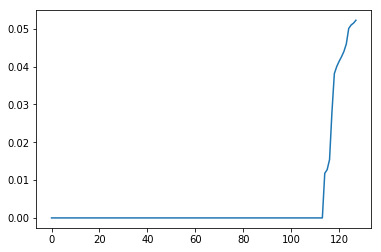

In [82]:
# 绘制fc1的权重std分布图
x = np.arange(0,len(sort_fc1_weights_std),step=1)
plt.plot(x,sort_fc1_weights_std)

删除std最小的96个kernel

In [86]:
pure_fc1_weight_index = np.where(fc1_weight_std >= sort_fc1_weights_std[96])
pure_fc1_weight = fc1_weight[:,pure_fc1_weight_index[0]]
pure_fc1_weight.shape

(384, 32)

In [87]:
# fc1 对应的bias 也做相同处理
pure_fc1_bias = fc1_bias[pure_fc1_weight_index[0]]
pure_fc1_bias

array([ 0.06933335,  0.02037769,  0.01464757,  0.02116067,  0.04195461,
        0.0135808 ,  0.01923977,  0.02196406,  0.04413285, -0.01887337,
        0.03099032,  0.01619267,  0.07307059,  0.01455008,  0.03278447,
       -0.00492902,  0.00954247,  0.04990456,  0.07606847,  0.01742192,
       -0.01366234,  0.03869563,  0.0078333 , -0.01284413,  0.02595759,
        0.10285708,  0.03164362, -0.03349329,  0.05203463,  0.0077379 ,
        0.02752118,  0.02503087], dtype=float32)

### 4.2 处理 fc1 接续的 fc2的权重

In [144]:
fc2_weight = reader.get_tensor("fc2/weights")
fc2_bias = reader.get_tensor("fc2/biases")

In [145]:
fc2_weight.shape

(128, 256)

In [146]:
# 只删减kernel 的 通道， 对bias无影响
fc2_weight = fc2_weight[pure_fc1_weight_index[0],:]

In [147]:
fc2_weight.shape

(32, 256)

In [148]:
fc2_bias.shape

(256,)

# 5. pure fc2的权重

### 5.1 处理fc2的权重

In [97]:
# 获得每个kernel的权重和
fc2_weight_sum = np.sum(fc2_weight, (0,))
sort_fc2_weights = np.sort(fc2_weight_sum)

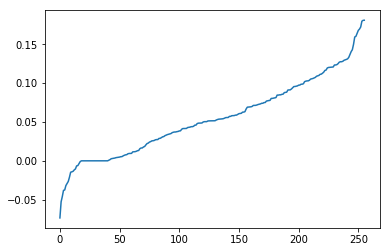

In [98]:
# 绘制fc2的权重和分布图
x = np.arange(0,len(sort_fc2_weights),step=1)
plt.plot(x,sort_fc2_weights)

In [100]:
# 获得每个kernel的std
fc2_weight_std = np.std(fc2_weight, (0,))
sort_fc2_weights_std = np.sort(fc2_weight_std)

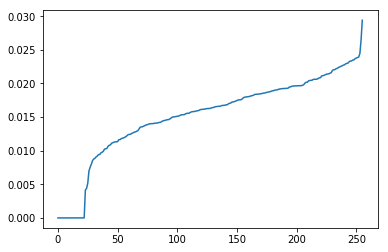

In [101]:
# 绘制fc1的权重std分布图
x = np.arange(0,len(sort_fc2_weights_std),step=1)
plt.plot(x,sort_fc2_weights_std)

数量较少，不再处理
获得剩余的层的权重

In [102]:
# 获得 logit 的权重
logits_weight = reader.get_tensor("logits/weights")
logits_bias = reader.get_tensor("logits/biases")

# 6. 将剪枝后的模型 图 与 权重打包为 pb 文件

In [120]:
channel_dict = {'conv1': pure_conv1_weight.shape[-1], 'conv2': pure_conv2_weight.shape[-1],
               'conv3':pure_conv3_weight.shape[-1], 'fc1': pure_fc1_weight.shape[-1], 
               'fc2': fc2_weight.shape[-1], 'logits': logits_weight.shape[-1]}

In [149]:
pure_weights = {'conv1/weights': pure_conv1_weight, 'conv1/biases': pure_conv1_bias,
               'conv2/weights': pure_conv2_weight, 'conv2/biases': pure_conv2_bias,
               'conv3/weights': pure_conv3_weight, 'conv3/biases': pure_conv3_bias,
               'fc1/weights': pure_fc1_weight, 'fc1/biases': pure_fc1_bias,
               'fc2/weights': fc2_weight, 'fc2/biases': fc2_bias,
               'logits/weights': logits_weight, 'logits/biases': logits_bias}

In [150]:
all_data = {}
all_data['channel_dict'] = channel_dict
all_data['pure_weights'] = pure_weights

In [151]:
with open('./pure_checkpoints/pure_1.pb', 'wb') as f:
    pickle.dump(all_data, f)

In [152]:
with open('./pure_checkpoints/pure_1.pb', 'rb') as f:
    load = pickle.load(f)

In [153]:
load['channel_dict']

{'conv1': 8, 'conv2': 16, 'conv3': 24, 'fc1': 32, 'fc2': 256, 'logits': 10}

In [154]:
load['pure_weights']

{'conv1/biases': array([ 0.00045041,  0.0262382 ,  0.0208248 , -0.00159773,  0.09998561,
        -0.00079513,  0.00963001, -0.00306746], dtype=float32),
 'conv1/weights': array([[[[ 6.3274127e-01,  2.5952822e-06,  3.1592351e-01,
            1.5402968e-03,  2.4988001e-06,  1.2688795e-06,
            1.3045588e+00, -1.0291224e-06]],
 
         [[ 5.4130714e-02, -2.5132947e-06,  8.8990194e-01,
            2.6030982e-01, -2.5798433e-06, -2.3896496e-07,
            1.2344695e+00, -3.0663159e-08]],
 
         [[ 3.9366769e-04,  2.3328214e-06,  9.3016773e-01,
            8.1906325e-01, -2.9581986e-06,  2.1187432e-06,
            3.0997133e-01,  2.9995022e-02]]],
 
 
        [[[ 9.1211623e-01,  1.3319841e-06,  3.0893216e-01,
            3.7858409e-01,  1.7236343e-06, -4.3532350e-07,
            1.0387123e+00, -1.9107795e-06]],
 
         [[ 1.0202506e+00,  1.6824222e-06,  7.1689355e-01,
            9.6778357e-01,  8.1113262e-07,  8.4306294e-08,
            9.9702322e-01, -7.5047205e-07]],
 
  